# 4.7.Transfer_Learning_MobileNet2_SGD_New_Head_v2_new_augmentation

In [ ]:
#!pip install sklearn
#!pip install imutils

In [1]:
import tensorflow as tf

from tensorflow.keras.applications import MobileNetV2

from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader

import matplotlib.pyplot as plt
import numpy as np

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Empezamos el entrenamiento

In [3]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from pyimagesearch.preprocessing import ImageToArrayPreprocessor
from pyimagesearch.preprocessing import AspectAwarePreprocessor
from pyimagesearch.datasets import SimpleDatasetLoader

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

from imutils import paths
import numpy as np
import os
import cv2

# Leemos la data

In [12]:
img_size = 224
path_train = 'data_' + str(img_size) + '/train'
path_validation = 'data_' + str(img_size) + '/validation'
path_checkpoints = 'checkpoint_MobileNet'

In [13]:
imagePaths_train = list(paths.list_images(path_train))
imagePaths_validation = list(paths.list_images(path_validation))
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths_train]
classNames = [str(x) for x in np.unique(classNames)]

print("etiquetas del entrenamiento")
print(classNames)

#Códificando las etiquetas en númerops
print("codificando etiquetas")
le = LabelEncoder()
classNames_ids = le.fit_transform(classNames)
print(classNames_ids)

etiquetas del entrenamiento
['100_espalda', '100_frente', '10_espalda', '10_frente', '200_espalda', '200_frente', '20_espalda', '20_frente', '50_espalda', '50_frente']
codificando etiquetas
[0 1 2 3 4 5 6 7 8 9]


In [ ]:
iap = ImageToArrayPreprocessor()
sdl = SimpleDatasetLoader(preprocessors=[iap])

print('Cargando data para el entrenamiento')
data_train, labels_train = sdl.load(imagePaths_train, verbose=5000)

print('Cargando data para la validación')
data_validation, labels_validation = sdl.load(imagePaths_validation, verbose=500)

print('Binarizando los labels')
labels_train = LabelBinarizer().fit_transform(labels_train)
labels_validation = LabelBinarizer().fit_transform(labels_validation)

print('Carga terminada')


# Creando el modelo base

In [14]:
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size,img_size,3)
)

# Congelamos las capas para el entrenamiento

In [15]:
for layer in base_model.layers:
    layer.trainable = True

# Creamos la nueva cabecera

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, MaxPooling2D

# Creamos varios modelos para luego realizar un ensamblaje

In [17]:
path_ensembles = 'ensembles_MobileNetV2'
batch_size = 32

# Entrenamiento

In [ ]:
'''
print('Normalizando los datos')
data_train = data_train.astype("float") / 255.0
data_validation = data_validation.astype("float") / 255.0

print('Generando la data para el entrenamiento')
aug_train = ImageDataGenerator()
aug_train.fit(data_train)
train_generator = aug_train.flow(data_train, labels_train, batch_size=batch_size)

aug_validation = ImageDataGenerator()
aug_validation.fit(data_validation)
validation_generator = aug_validation.flow(data_validation, labels_validation, batch_size=batch_size)
print('Terminado')
'''

In [18]:
aug_train = ImageDataGenerator(rescale=1. / 255)
#aug_train.fit(data_train)
train_generator = aug_train.flow_from_directory(path_train,
                                                target_size=(img_size, img_size),
                                                batch_size=batch_size)

Found 16752 images belonging to 10 classes.


In [19]:
aug_validation = ImageDataGenerator(rescale=1. / 255)
#aug_validation.fit(data_validation)
validation_generator = aug_validation.flow_from_directory(path_validation,
                                                          target_size=(img_size, img_size),
                                                          batch_size=batch_size)

Found 2671 images belonging to 10 classes.


In [33]:
model = tf.keras.Sequential([
                              base_model,
                              Flatten(),
                              Dropout(0.2),
                              Dense(1024, activation='relu'),
                              Dense(1024, activation='relu'),
                              Dense(1024, activation='relu'),
                              Dropout(0.2),
                              Dense(512, activation='relu'),
                              Dense(512, activation='relu'),
                              Dense(512, activation='relu'),
                              Dropout(0.2),
                              Dense(128, activation='relu'),
                              Dense(128, activation='relu'),
                              Dense(64, activation='relu'),
                              Dense(64, activation='relu'),
                              Dense(32, activation='relu'),
                              Dense(len(classNames_ids), activation='softmax')
                            ])

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 62720)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 1024)              64226304  
_________________________________________________________________
dense_23 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)             

In [35]:
#optimizer = Adam(learning_rate=0.0001)
#optimizer = RMSprop(learning_rate=0.0001)
optimizer = SGD(learning_rate=0.0001)

loss = 'categorical_crossentropy'
metrics=["accuracy"]

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)


# Configurando checkpoint

In [36]:
fname = os.path.sep.join([path_checkpoints, 
                          'epoch-{epoch:03d}-val_loss:{val_loss:.4f}-val_accuracy:{val_accuracy:.4f}.hdf5'])
checkpoint = ModelCheckpoint(fname,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)
callbacks = [checkpoint]
#callbacks = []

In [37]:
epochs = 400
#entrenando el modelo
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              validation_data=validation_generator,
                              epochs = epochs,
                              callbacks=callbacks,
                              verbose = 1)

Epoch 1/400
524/524 [==============================] - ETA: 0s - loss: 2.3094 - accuracy: 0.0870
Epoch 00001: val_accuracy improved from -inf to 0.09809, saving model to checkpoint_MobileNet/epoch-001-val_loss:2.3036-val_accuracy:0.0981.hdf5
524/524 [==============================] - 75s 144ms/step - loss: 2.3094 - accuracy: 0.0870 - val_loss: 2.3036 - val_accuracy: 0.0981
Epoch 2/400
524/524 [==============================] - ETA: 0s - loss: 2.2996 - accuracy: 0.0878
Epoch 00002: val_accuracy did not improve from 0.09809
524/524 [==============================] - 73s 140ms/step - loss: 2.2996 - accuracy: 0.0878 - val_loss: 2.2982 - val_accuracy: 0.0936
Epoch 3/400
524/524 [==============================] - ETA: 0s - loss: 2.2905 - accuracy: 0.0926
Epoch 00003: val_accuracy improved from 0.09809 to 0.10071, saving model to checkpoint_MobileNet/epoch-003-val_loss:2.2928-val_accuracy:0.1007.hdf5
524/524 [==============================] - 74s 141ms/step - loss: 2.2905 - accuracy: 0.0926 -

524/524 [==============================] - ETA: 0s - loss: 0.2295 - accuracy: 0.9525
Epoch 00022: val_accuracy improved from 0.58330 to 0.59116, saving model to checkpoint_MobileNet/epoch-022-val_loss:1.3647-val_accuracy:0.5912.hdf5
524/524 [==============================] - 74s 140ms/step - loss: 0.2295 - accuracy: 0.9525 - val_loss: 1.3647 - val_accuracy: 0.5912
Epoch 23/400
524/524 [==============================] - ETA: 0s - loss: 0.1780 - accuracy: 0.9649
Epoch 00023: val_accuracy did not improve from 0.59116
524/524 [==============================] - 73s 140ms/step - loss: 0.1780 - accuracy: 0.9649 - val_loss: 1.4601 - val_accuracy: 0.5878
Epoch 24/400
524/524 [==============================] - ETA: 0s - loss: 0.1468 - accuracy: 0.9685
Epoch 00024: val_accuracy improved from 0.59116 to 0.59865, saving model to checkpoint_MobileNet/epoch-024-val_loss:1.4556-val_accuracy:0.5987.hdf5
524/524 [==============================] - 74s 140ms/step - loss: 0.1468 - accuracy: 0.9685 - val_lo

524/524 [==============================] - ETA: 0s - loss: 0.0236 - accuracy: 0.9942
Epoch 00048: val_accuracy did not improve from 0.62261
524/524 [==============================] - 73s 139ms/step - loss: 0.0236 - accuracy: 0.9942 - val_loss: 1.8474 - val_accuracy: 0.6174
Epoch 49/400
524/524 [==============================] - ETA: 0s - loss: 0.0241 - accuracy: 0.9934
Epoch 00049: val_accuracy did not improve from 0.62261
524/524 [==============================] - 73s 139ms/step - loss: 0.0241 - accuracy: 0.9934 - val_loss: 1.8444 - val_accuracy: 0.6200
Epoch 50/400
524/524 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9934
Epoch 00050: val_accuracy did not improve from 0.62261
524/524 [==============================] - 73s 140ms/step - loss: 0.0244 - accuracy: 0.9934 - val_loss: 1.8415 - val_accuracy: 0.6192
Epoch 51/400
524/524 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9949
Epoch 00051: val_accuracy did not improve from 0.62261

524/524 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9961
Epoch 00076: val_accuracy did not improve from 0.62486
524/524 [==============================] - 73s 139ms/step - loss: 0.0134 - accuracy: 0.9961 - val_loss: 2.0193 - val_accuracy: 0.6211
Epoch 77/400
524/524 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.9970
Epoch 00077: val_accuracy did not improve from 0.62486
524/524 [==============================] - 73s 139ms/step - loss: 0.0118 - accuracy: 0.9970 - val_loss: 2.0185 - val_accuracy: 0.6207
Epoch 78/400
524/524 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9976
Epoch 00078: val_accuracy did not improve from 0.62486
524/524 [==============================] - 73s 139ms/step - loss: 0.0103 - accuracy: 0.9976 - val_loss: 2.0029 - val_accuracy: 0.6222
Epoch 79/400
524/524 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 0.9977
Epoch 00079: val_accuracy did not improve from 0.62486

524/524 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.9981
Epoch 00104: val_accuracy did not improve from 0.62673
524/524 [==============================] - 73s 140ms/step - loss: 0.0081 - accuracy: 0.9981 - val_loss: 2.0692 - val_accuracy: 0.6260
Epoch 105/400
524/524 [==============================] - ETA: 0s - loss: 0.0077 - accuracy: 0.9977
Epoch 00105: val_accuracy did not improve from 0.62673
524/524 [==============================] - 73s 140ms/step - loss: 0.0077 - accuracy: 0.9977 - val_loss: 2.1102 - val_accuracy: 0.6241
Epoch 106/400
524/524 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9976
Epoch 00106: val_accuracy did not improve from 0.62673
524/524 [==============================] - 73s 140ms/step - loss: 0.0078 - accuracy: 0.9976 - val_loss: 2.0620 - val_accuracy: 0.6264
Epoch 107/400
524/524 [==============================] - ETA: 0s - loss: 0.0077 - accuracy: 0.9977
Epoch 00107: val_accuracy did not improve from 0.62

Epoch 133/400
524/524 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9983
Epoch 00133: val_accuracy did not improve from 0.62673
524/524 [==============================] - 73s 140ms/step - loss: 0.0060 - accuracy: 0.9983 - val_loss: 2.1545 - val_accuracy: 0.6267
Epoch 134/400
524/524 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9987
Epoch 00134: val_accuracy did not improve from 0.62673
524/524 [==============================] - 71s 135ms/step - loss: 0.0059 - accuracy: 0.9987 - val_loss: 2.1683 - val_accuracy: 0.6249
Epoch 135/400
524/524 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9986
Epoch 00135: val_accuracy did not improve from 0.62673
524/524 [==============================] - 73s 139ms/step - loss: 0.0054 - accuracy: 0.9986 - val_loss: 2.1791 - val_accuracy: 0.6241
Epoch 136/400
524/524 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9986
Epoch 00136: val_accuracy did not imp

524/524 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9987
Epoch 00161: val_accuracy improved from 0.62898 to 0.62935, saving model to checkpoint_MobileNet/epoch-161-val_loss:2.2362-val_accuracy:0.6294.hdf5
524/524 [==============================] - 72s 138ms/step - loss: 0.0043 - accuracy: 0.9987 - val_loss: 2.2362 - val_accuracy: 0.6294
Epoch 162/400
524/524 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9986
Epoch 00162: val_accuracy improved from 0.62935 to 0.63048, saving model to checkpoint_MobileNet/epoch-162-val_loss:2.2374-val_accuracy:0.6305.hdf5
524/524 [==============================] - 73s 140ms/step - loss: 0.0058 - accuracy: 0.9986 - val_loss: 2.2374 - val_accuracy: 0.6305
Epoch 163/400
524/524 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9990
Epoch 00163: val_accuracy did not improve from 0.63048
524/524 [==============================] - 73s 139ms/step - loss: 0.0042 - accuracy: 0.9990 - val_

Epoch 189/400
524/524 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9987
Epoch 00189: val_accuracy did not improve from 0.63235
524/524 [==============================] - 73s 139ms/step - loss: 0.0035 - accuracy: 0.9987 - val_loss: 2.2282 - val_accuracy: 0.6301
Epoch 190/400
524/524 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9990
Epoch 00190: val_accuracy did not improve from 0.63235
524/524 [==============================] - 72s 138ms/step - loss: 0.0050 - accuracy: 0.9990 - val_loss: 2.2382 - val_accuracy: 0.6301
Epoch 191/400
524/524 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9993
Epoch 00191: val_accuracy did not improve from 0.63235
524/524 [==============================] - 72s 137ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 2.2756 - val_accuracy: 0.6279
Epoch 192/400
524/524 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9988
Epoch 00192: val_accuracy did not imp

Epoch 218/400
524/524 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.9992
Epoch 00218: val_accuracy did not improve from 0.63235
524/524 [==============================] - 73s 140ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 2.3623 - val_accuracy: 0.6230
Epoch 219/400
524/524 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 0.9996
Epoch 00219: val_accuracy did not improve from 0.63235
524/524 [==============================] - 73s 140ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 2.3403 - val_accuracy: 0.6234
Epoch 220/400
524/524 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9993
Epoch 00220: val_accuracy did not improve from 0.63235
524/524 [==============================] - 73s 139ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 2.3480 - val_accuracy: 0.6237
Epoch 221/400
524/524 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9995
Epoch 00221: val_accuracy did not imp

Epoch 247/400
524/524 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.9993
Epoch 00247: val_accuracy did not improve from 0.63235
524/524 [==============================] - 73s 140ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 2.3582 - val_accuracy: 0.6249
Epoch 248/400
524/524 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9992
Epoch 00248: val_accuracy did not improve from 0.63235
524/524 [==============================] - 73s 140ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 2.3673 - val_accuracy: 0.6264
Epoch 249/400
524/524 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.9990
Epoch 00249: val_accuracy did not improve from 0.63235
524/524 [==============================] - 73s 139ms/step - loss: 0.0028 - accuracy: 0.9990 - val_loss: 2.3644 - val_accuracy: 0.6252
Epoch 250/400
524/524 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.9988
Epoch 00250: val_accuracy did not imp

Epoch 276/400
524/524 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.9995
Epoch 00276: val_accuracy did not improve from 0.63235
524/524 [==============================] - 73s 138ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 2.3737 - val_accuracy: 0.6264
Epoch 277/400
524/524 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9992
Epoch 00277: val_accuracy did not improve from 0.63235
524/524 [==============================] - 73s 139ms/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 2.3736 - val_accuracy: 0.6260
Epoch 278/400
524/524 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9993
Epoch 00278: val_accuracy did not improve from 0.63235
524/524 [==============================] - 73s 139ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 2.3702 - val_accuracy: 0.6271
Epoch 279/400
524/524 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9992
Epoch 00279: val_accuracy did not imp

Epoch 305/400
524/524 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.9997
Epoch 00305: val_accuracy did not improve from 0.63235
524/524 [==============================] - 73s 139ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 2.3946 - val_accuracy: 0.6290
Epoch 306/400
524/524 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 0.9994
Epoch 00306: val_accuracy did not improve from 0.63235
524/524 [==============================] - 73s 139ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 2.4000 - val_accuracy: 0.6260
Epoch 307/400
524/524 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9997
Epoch 00307: val_accuracy did not improve from 0.63235
524/524 [==============================] - 73s 140ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 2.3983 - val_accuracy: 0.6256
Epoch 308/400
524/524 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9996
Epoch 00308: val_accuracy did not imp

Epoch 334/400
524/524 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9996
Epoch 00334: val_accuracy did not improve from 0.63235
524/524 [==============================] - 73s 140ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 2.3830 - val_accuracy: 0.6294
Epoch 335/400
524/524 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9997
Epoch 00335: val_accuracy did not improve from 0.63235
524/524 [==============================] - 73s 139ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 2.3712 - val_accuracy: 0.6297
Epoch 336/400
524/524 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9996
Epoch 00336: val_accuracy did not improve from 0.63235
524/524 [==============================] - 73s 140ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 2.3910 - val_accuracy: 0.6308
Epoch 337/400
524/524 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0.9996
Epoch 00337: val_accuracy did not imp

Epoch 362/400
524/524 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9988
Epoch 00362: val_accuracy did not improve from 0.63534
524/524 [==============================] - 71s 136ms/step - loss: 0.0030 - accuracy: 0.9988 - val_loss: 2.4538 - val_accuracy: 0.6275
Epoch 363/400
524/524 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.9995
Epoch 00363: val_accuracy did not improve from 0.63534
524/524 [==============================] - 73s 139ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 2.4573 - val_accuracy: 0.6286
Epoch 364/400
524/524 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9996
Epoch 00364: val_accuracy did not improve from 0.63534
524/524 [==============================] - 73s 139ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 2.4489 - val_accuracy: 0.6294
Epoch 365/400
524/524 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9998
Epoch 00365: val_accuracy did not imp

Epoch 391/400
524/524 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.9993
Epoch 00391: val_accuracy did not improve from 0.63534
524/524 [==============================] - 73s 139ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 2.4885 - val_accuracy: 0.6275
Epoch 392/400
524/524 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9995
Epoch 00392: val_accuracy did not improve from 0.63534
524/524 [==============================] - 73s 139ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 2.4846 - val_accuracy: 0.6286
Epoch 393/400
524/524 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9993
Epoch 00393: val_accuracy did not improve from 0.63534
524/524 [==============================] - 73s 139ms/step - loss: 0.0017 - accuracy: 0.9993 - val_loss: 2.4691 - val_accuracy: 0.6294
Epoch 394/400
524/524 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 0.9999
Epoch 00394: val_accuracy did not imp

In [38]:
#guardando el modelo
p = [path_ensembles, "model_head_v2_new_augmentation_400_SGD.model"]
model.save(os.path.sep.join(p))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ensembles_MobileNetV2/model_head_v2_new_augmentation_400_SGD.model/assets


In [ ]:
#evaluando el modelo
predictions = model.predict(data_validation, batch_size=batch_size)
print(classification_report(labels_validation.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=classNames))

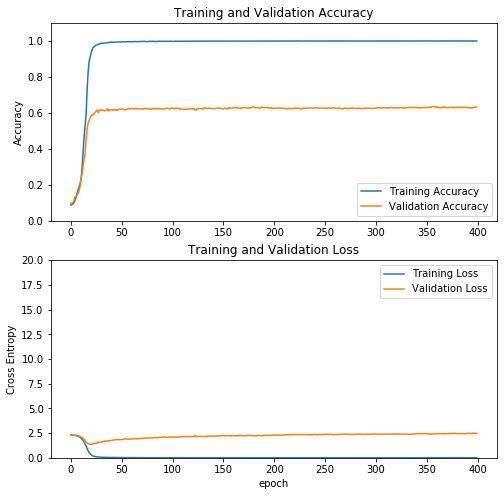

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.ylim([0,20])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Tomando 25 imágenes de validación y observando el resultado

INFO:tensorflow:Load image with size: 2671, num_label: 10, labels: 100_espalda, 100_frente, 10_espalda, 10_frente, 200_espalda, 200_frente, 20_espalda, 20_frente, 50_espalda, 50_frente.


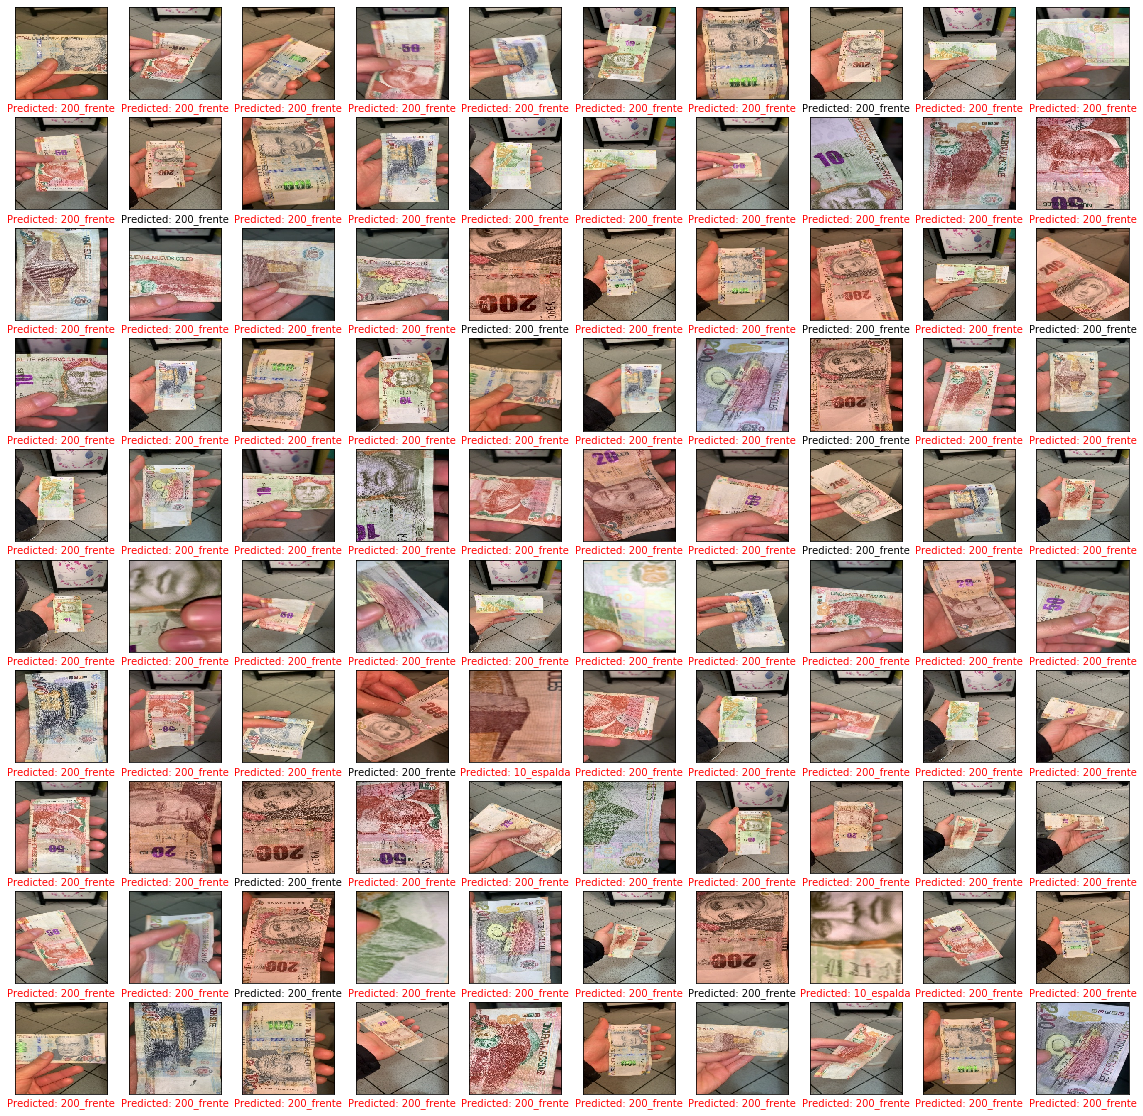

In [40]:
test_data = ImageClassifierDataLoader.from_folder(path_validation)

def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(test_data.dataset.take(100)):
    ax = plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)
    
    # predict
    swapped = np.moveaxis(image, 0, 1)
    arr4d = np.expand_dims(swapped, 0)
    id_predict = np.argmax(model.predict(arr4d))
    predict_label = classNames[id_predict]
    
    color = get_label_color(predict_label, test_data.index_to_label[label.numpy()])
    #color = 'black'
    ax.xaxis.label.set_color(color)
    plt.xlabel('Predicted: %s' % predict_label)
plt.show()